In [1]:
# 1. 数据加载与预处理 
import os
import torch
import numpy as np
from torch_geometric.data import Data
from tqdm import tqdm

# 设置数据路径
data_path = r'G:\000_New_data\Local\Local_Region\Phase49Aspect1_Local_Region\LocalSize21'

# 加载所有文件
all_files = [f for f in os.listdir(data_path) if f.endswith('.txt')]

# 按样本分组
sample_groups = {}
for f in all_files:
    parts = f.split('_')
    if len(parts) >= 3:
        group_key = '_'.join(parts[:2])
        node_part = parts[-1].split('.')[0]
        
        try:
            node_id = int(node_part) - 1
            if group_key not in sample_groups:
                sample_groups[group_key] = {
                    'micro': {},
                    'mfrac': {},
                    'damage': {}
                }
            
            if 'MicroInfo' in f:
                sample_groups[group_key]['micro'][node_id] = f
            elif 'Mfraction' in f:
                sample_groups[group_key]['mfrac'][node_id] = f
            elif 'DamageStrain' in f:
                sample_groups[group_key]['damage'][node_id] = f
        except ValueError:
            continue


# 在预处理代码中修改样本处理循环
graphs = []
file_info = []

for group_key, file_dicts in sample_groups.items():
    # 检查是否满足5个节点
    if len(file_dicts['micro']) == 5 and len(file_dicts['mfrac']) == 5 and len(file_dicts['damage']) == 5:
        # 按节点ID排序（使用字典的items()）
        sorted_micro_nodes = sorted(file_dicts['micro'].items(), key=lambda x: x[0])
        sorted_mfrac_nodes = sorted(file_dicts['mfrac'].items(), key=lambda x: x[0])
        sorted_damage_nodes = sorted(file_dicts['damage'].items(), key=lambda x: x[0])
        
        # 处理文件信息
        file_info.append({
            'micro': [os.path.join(data_path, f[1]) for f in sorted_micro_nodes],
            'mfrac': [os.path.join(data_path, f[1]) for f in sorted_mfrac_nodes],
            'damage': [os.path.join(data_path, f[1]) for f in sorted_damage_nodes]
        })
        
        # 1. 收集Mfraction值
        mfraction_values = []
        for node_id, filename in sorted_mfrac_nodes:
            try:
                with open(os.path.join(data_path, filename), 'r') as f:
                    first_line = f.readline().strip()
                    if first_line:
                        try:
                            mfraction_values.append(float(first_line.split()[0]))
                        except:
                            mfraction_values.append(0.0)
                    else:
                        mfraction_values.append(0.0)
            except:
                mfraction_values.append(0.0)
        
        # 2. 处理微观结构特征
        node_features = []
        for node_id, filename in sorted_micro_nodes:
            with open(os.path.join(data_path, filename), 'r') as f:
                features = []
                for line in f:
                    value = line.strip().split(',')[0]
                    try:
                        features.append(float(value))
                    except:
                        features.append(0.0)
                
                if len(features) == 441:
                    features = np.array(features).reshape(21, 21)
                    features_with_mfraction = np.append(features.flatten(), mfraction_values[node_id])
                    node_features.append(features_with_mfraction)
                else:
                    default_features = np.zeros((21, 21)).flatten()
                    features_with_mfraction = np.append(default_features, mfraction_values[node_id])
                    node_features.append(features_with_mfraction)
        
        # 3. 构建图结构
        edge_index = torch.tensor([
            [0, 1, 2, 3],
            [1, 2, 3, 4]
        ], dtype=torch.long)
        
        # 4. 读取损伤应变值
        y_values = []
        for node_id, filename in sorted_damage_nodes:
            try:
                with open(os.path.join(data_path, filename), 'r') as f:
                    line = f.readline().strip()
                    if line:
                        try:
                            y_values.append(float(line.split(',')[0]))
                        except:
                            y_values.append(0.0)
                    else:
                        y_values.append(0.0)
            except:
                y_values.append(0.0)
        
        x = torch.tensor(node_features, dtype=torch.float)
        y = torch.tensor(y_values, dtype=torch.float).unsqueeze(1)
        
        data = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(data)

# 查看结果
print(f"成功加载 {len(graphs)} 个图数据样本")
print("第一个样本信息:")
print(graphs[0])
print("节点特征维度:", graphs[0].x.shape)
print("边索引:", graphs[0].edge_index)
print("标签:", graphs[0].y)

C:\Users\86157\AppData\Local\Temp\ipykernel_15248\3010923926.py:119: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  x = torch.tensor(node_features, dtype=torch.float)


成功加载 125 个图数据样本
第一个样本信息:
Data(x=[5, 442], edge_index=[2, 4], y=[5, 1])
节点特征维度: torch.Size([5, 442])
边索引: tensor([[0, 1, 2, 3],
        [1, 2, 3, 4]])
标签: tensor([[0.1800],
        [0.1850],
        [0.2200],
        [0.2300],
        [0.2350]])


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from tqdm import tqdm
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.metrics import r2_score, mean_squared_error
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, MessagePassing  # 确保导入了GCNConv
from torch_geometric.utils import add_self_loops

# 2. 模型定义
class GatedFusion(nn.Module):
    def __init__(self, cnn_dim):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 800), 
            nn.Sigmoid()
        )
        self.mfrac_boost = nn.Parameter(torch.tensor(3.0))
        self.spatial_groups = 25
        self.channels_per_group = cnn_dim // self.spatial_groups

    def forward(self, cnn_feat, mfrac):
        gate_weights = self.gate(mfrac)
        grouped_weights = gate_weights.view(-1, self.channels_per_group, self.spatial_groups)
        spatial_weights = grouped_weights.mean(dim=1)
        expanded_weights = spatial_weights.unsqueeze(1).repeat(1, self.channels_per_group, 1)
        gate_weights = expanded_weights.reshape_as(gate_weights)
        gate_weights = gate_weights * 2.0
        boosted_mfrac = mfrac * self.mfrac_boost
        return torch.cat([cnn_feat * gate_weights, boosted_mfrac], dim=1), gate_weights

class Optimized_CNN_GCN(nn.Module):
    def __init__(self, input_dim=(21, 21), filters=32, kernel_size=3, 
                 dense_units=64, dropout_rate=0, gcn_hidden_dim=64, 
                 learning_rate=0.001):
        super(Optimized_CNN_GCN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, *input_dim)
            dummy_output = self.cnn(dummy_input)
            self.cnn_output_dim = dummy_output.view(-1).shape[0]
        
        self.fusion = GatedFusion(self.cnn_output_dim)
        self.conv1 = GCNConv(self.cnn_output_dim + 1, gcn_hidden_dim)
        self.conv2 = GCNConv(gcn_hidden_dim, gcn_hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(gcn_hidden_dim, 1)
#         self.sigmoid = nn.Sigmoid() # 添加Sigmoid激活函数
        self.learning_rate = learning_rate
        
        
        # 添加属性以支持可视化
        self.gate_weights = None
        self.attn_weights = None
        self.conv1_attention = torch.randn(4, 1)  # 随机生成假数据用于可视化
        self.conv2_attention = torch.randn(4, 1)  # 随机生成假数据用于可视化
        
    def forward(self, data):
        x_all = data.x
        num_nodes = data.num_nodes
        x_cnn = x_all[:, :-1].view(num_nodes, 1, 21, 21)
        x_mfrac = x_all[:, -1].unsqueeze(1)
        x_cnn = self.cnn(x_cnn)
        x_cnn = x_cnn.view(num_nodes, -1)
        
        x, gate_weights = self.fusion(x_cnn, x_mfrac)
        self.gate_weights = gate_weights
        self.attn_weights = torch.randn(num_nodes, 1)  # 随机生成假数据用于可视化
        
        edge_index = data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
#         x = self.sigmoid(x)  # 应用Sigmoid
        return x
    
# 即时测试模型
sample_data = graphs[0]  # 使用第一个样本测试
model = Optimized_CNN_GCN()
output = model(sample_data)
print("\n模型测试输出:")
print(output.shape)
print(output)

# 查看模型结构
print("\n模型结构:")
print(model)


模型测试输出:
torch.Size([5, 1])
tensor([[-0.1162],
        [-0.1164],
        [-0.1127],
        [-0.1127],
        [-0.1170]], grad_fn=<AddmmBackward0>)

模型结构:
Optimized_CNN_GCN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fusion): GatedFusion(
    (gate): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=800, bias=True)
      (5): Sigmoid()
    )
  )
  (conv1): GCNConv(801, 64)
  (conv2): GCNConv(64, 64)
  (dropout): Dropout(p=0, inplace=False)
  (linear): Linear(in_features=64, out_features=1,

In [3]:
# 3. 训练过程 - 即时运行
from torch_geometric.data import DataLoader
from sklearn.model_selection import ParameterGrid
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 设置随机种子
torch.manual_seed(41)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(41)
np.random.seed(41)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 准备数据加载器
np.random.shuffle(graphs)
train_dataset = graphs[:int(0.7*len(graphs))]
val_dataset = graphs[int(0.7*len(graphs)):int(0.85*len(graphs))]
test_dataset = graphs[int(0.85*len(graphs)):]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Optimized_CNN_GCN(
#     filters=64,
#     kernel_size=5,
#     dense_units=64,
#     dropout_rate=0.3,
#     gcn_hidden_dim=32,
#     learning_rate=0.0015
# ).to(device)
model = Optimized_CNN_GCN(
    filters=32,
    kernel_size=5,
    dense_units=128,
    dropout_rate=0.2,
    gcn_hidden_dim=32,
    learning_rate=0.0015
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
criterion = nn.MSELoss()

# 训练参数
epochs = 200
patience = 20
min_delta = 0.00001

# 训练记录
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
best_val_loss = float('inf')
best_model_state = None
early_stop_counter = 0

# 训练循环
for epoch in range(epochs):
    # 训练阶段
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.num_graphs
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 验证阶段
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            val_loss += loss.item() * data.num_graphs
            val_preds.append(out.cpu().numpy())
            val_targets.append(data.y.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # 计算R2分数
    val_preds = np.concatenate(val_preds, axis=0)
    val_targets = np.concatenate(val_targets, axis=0)
    val_r2 = r2_score(val_targets, val_preds)
    val_r2_scores.append(val_r2)
    
    # 训练集评估
    model.eval()
    train_preds = []
    train_targets = []
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            out = model(data)
            train_preds.append(out.cpu().numpy())
            train_targets.append(data.y.cpu().numpy())
    train_preds = np.concatenate(train_preds, axis=0)
    train_targets = np.concatenate(train_targets, axis=0)
    train_r2 = r2_score(train_targets, train_preds)
    train_r2_scores.append(train_r2)
    
    # 早停检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    # 打印进度
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, '
              f'Train R2: {train_r2:.5f}, Val R2: {val_r2:.5f}')
    
    # 早停触发时保存模型
    if early_stop_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        torch.save(best_model_state, 'best_model.pth')  # <-- 添加在这里
        print("最佳模型已保存为 best_model.pth")
        break

# 正常完成训练时保存模型
if early_stop_counter < patience:
    torch.save(best_model_state, 'best_model.pth')
    print("训练完成，最佳模型已保存为 best_model.pth")

# 加载最佳模型进行测试评估
model.load_state_dict(best_model_state)
model.eval()

# 测试集评估
model.eval()
test_loss = 0
test_preds = []
test_targets = []
test_node_ids = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        test_loss += loss.item() * data.num_graphs
        test_preds.append(out.cpu().numpy())
        test_targets.append(data.y.cpu().numpy())
        
        batch_size = data.num_graphs
        num_nodes = data.x.size(0) // batch_size
        node_ids = np.tile(np.arange(num_nodes), batch_size)
        test_node_ids.append(node_ids)

test_loss /= len(test_loader.dataset)
test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)
test_node_ids = np.concatenate(test_node_ids, axis=0)
test_r2 = r2_score(test_targets, test_preds)



# 计算训练集指标
model.eval()
train_preds = []
train_targets = []
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        train_preds.append(out.cpu().numpy())
        train_targets.append(data.y.cpu().numpy())
train_preds = np.concatenate(train_preds, axis=0)
train_targets = np.concatenate(train_targets, axis=0)

# 计算验证集指标
val_preds = []
val_targets = []
with torch.no_grad():
    for data in val_loader:
        data = data.to(device)
        out = model(data)
        val_preds.append(out.cpu().numpy())
        val_targets.append(data.y.cpu().numpy())
val_preds = np.concatenate(val_preds, axis=0)
val_targets = np.concatenate(val_targets, axis=0)

# 计算测试集指标（已在前面计算）
# test_preds 和 test_targets 已经计算过

# 定义计算指标的函数
def calculate_metrics(targets, preds):
    mse = np.mean((targets - preds) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(targets - preds))
    r2 = r2_score(targets, preds)
    return rmse, mae, r2

# 计算各集的指标
train_rmse, train_mae, train_r2 = calculate_metrics(train_targets, train_preds)
val_rmse, val_mae, val_r2 = calculate_metrics(val_targets, val_preds)
test_rmse, test_mae, test_r2 = calculate_metrics(test_targets, test_preds)

# 打印结果
print('\n=== 最终结果 ===')
print('训练集 - RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(train_rmse, train_mae, train_r2))
print('验证集 - RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(val_rmse, val_mae, val_r2))
print('测试集 - RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}'.format(test_rmse, test_mae, test_r2))

# print('\n=== 最终结果 ===')
# print(f'测试集 - Loss: {test_loss:.4f}, R2: {test_r2:.4f}')

C:\Users\86157\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 5/200: Train Loss: 0.01730, Val Loss: 0.01433, Train R2: -0.41692, Val R2: -0.53677
Epoch 10/200: Train Loss: 0.01215, Val Loss: 0.01340, Train R2: -0.31549, Val R2: -0.43725
Epoch 15/200: Train Loss: 0.01071, Val Loss: 0.01115, Train R2: -0.11259, Val R2: -0.19583
Epoch 20/200: Train Loss: 0.00765, Val Loss: 0.00793, Train R2: 0.19279, Val R2: 0.14987
Epoch 25/200: Train Loss: 0.00526, Val Loss: 0.00500, Train R2: 0.47168, Val R2: 0.46364
Epoch 30/200: Train Loss: 0.00384, Val Loss: 0.00386, Train R2: 0.58340, Val R2: 0.58595
Epoch 35/200: Train Loss: 0.00298, Val Loss: 0.00314, Train R2: 0.76008, Val R2: 0.66384
Epoch 40/200: Train Loss: 0.00244, Val Loss: 0.00298, Train R2: 0.69965, Val R2: 0.68076
Epoch 45/200: Train Loss: 0.00266, Val Loss: 0.00255, Train R2: 0.78230, Val R2: 0.72711
Epoch 50/200: Train Loss: 0.00230, Val Loss: 0.00242, Train R2: 0.82620, Val R2: 0.74067
Epoch 55/200: Train Loss: 0.00211, Val Loss: 0.00240, Train R2: 0.82262, Val R2: 0.74270
Epoch 60/200: Tr

In [4]:
def check_distribution(dataset, name):
    features = torch.cat([data.x for data in dataset], dim=0)
    print(f"{name} - 特征均值: {features.mean():.4f}, 方差: {features.var():.4f}")

check_distribution(train_dataset, "训练集")
check_distribution(test_dataset, "测试集")

训练集 - 特征均值: 1.2188, 方差: 0.1744
测试集 - 特征均值: 1.2226, 方差: 0.1766


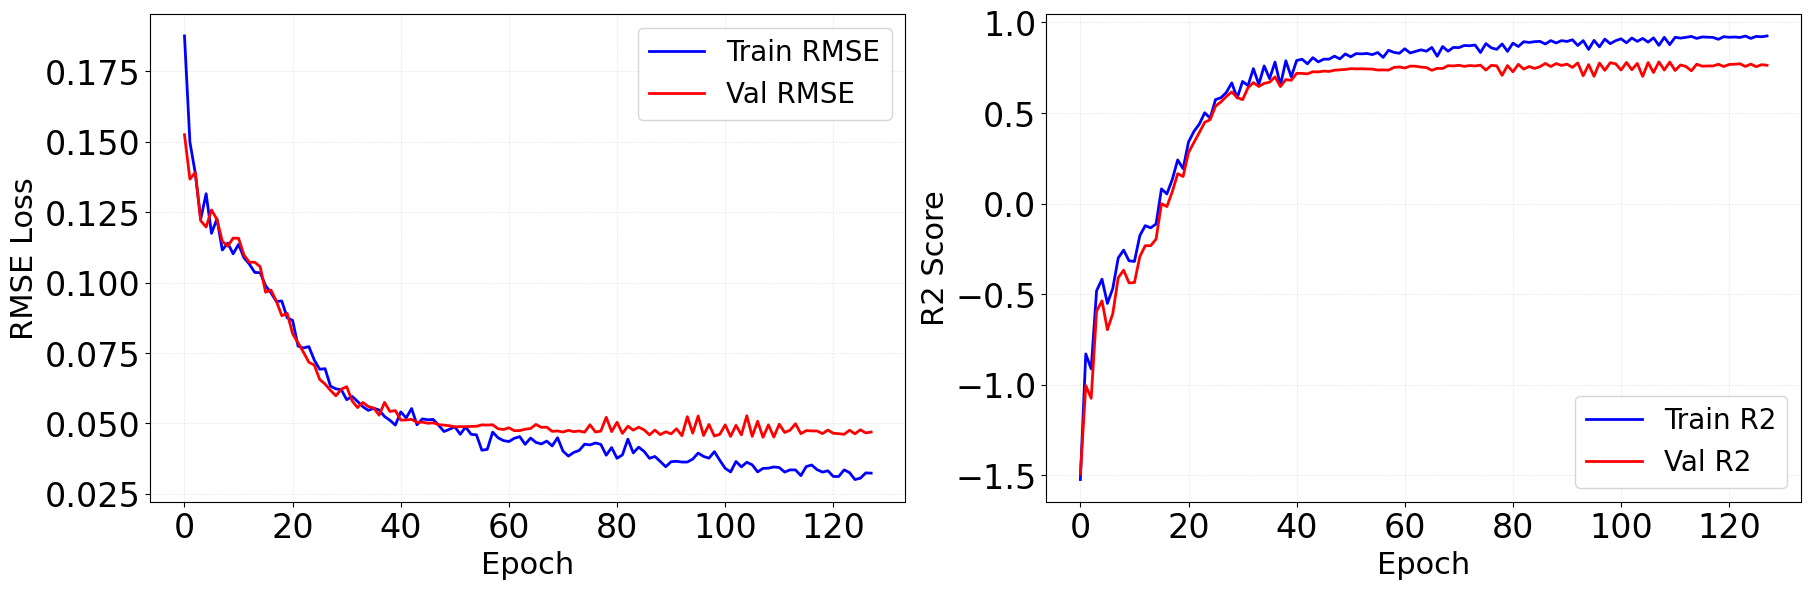

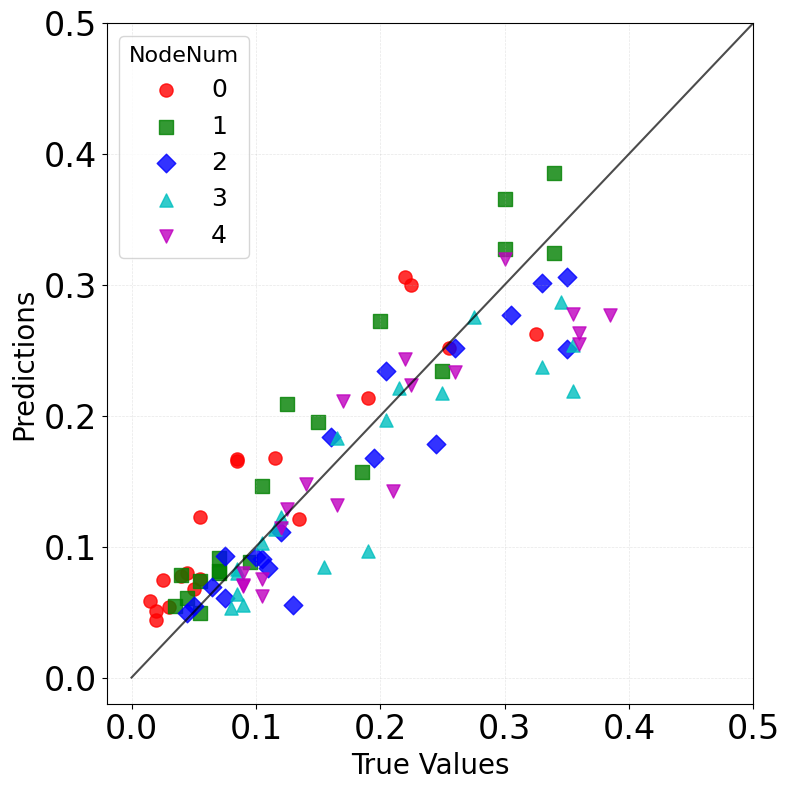


=== 节点预测性能评估 ===
节点    样本数     MSE         RMSE        R2        
--------------------------------------------------
2     19      0.0014330.0378570.8639
1     19      0.0014580.0381800.8682
0     19      0.0025310.0503130.6955
4     19      0.0026720.0516900.7410
3     19      0.0030770.0554710.6832

按R2排序:
节点1: R2=0.8682, RMSE=0.0382, MSE=0.001458
节点2: R2=0.8639, RMSE=0.0379, MSE=0.001433
节点4: R2=0.7410, RMSE=0.0517, MSE=0.002672
节点0: R2=0.6955, RMSE=0.0503, MSE=0.002531
节点3: R2=0.6832, RMSE=0.0555, MSE=0.003077


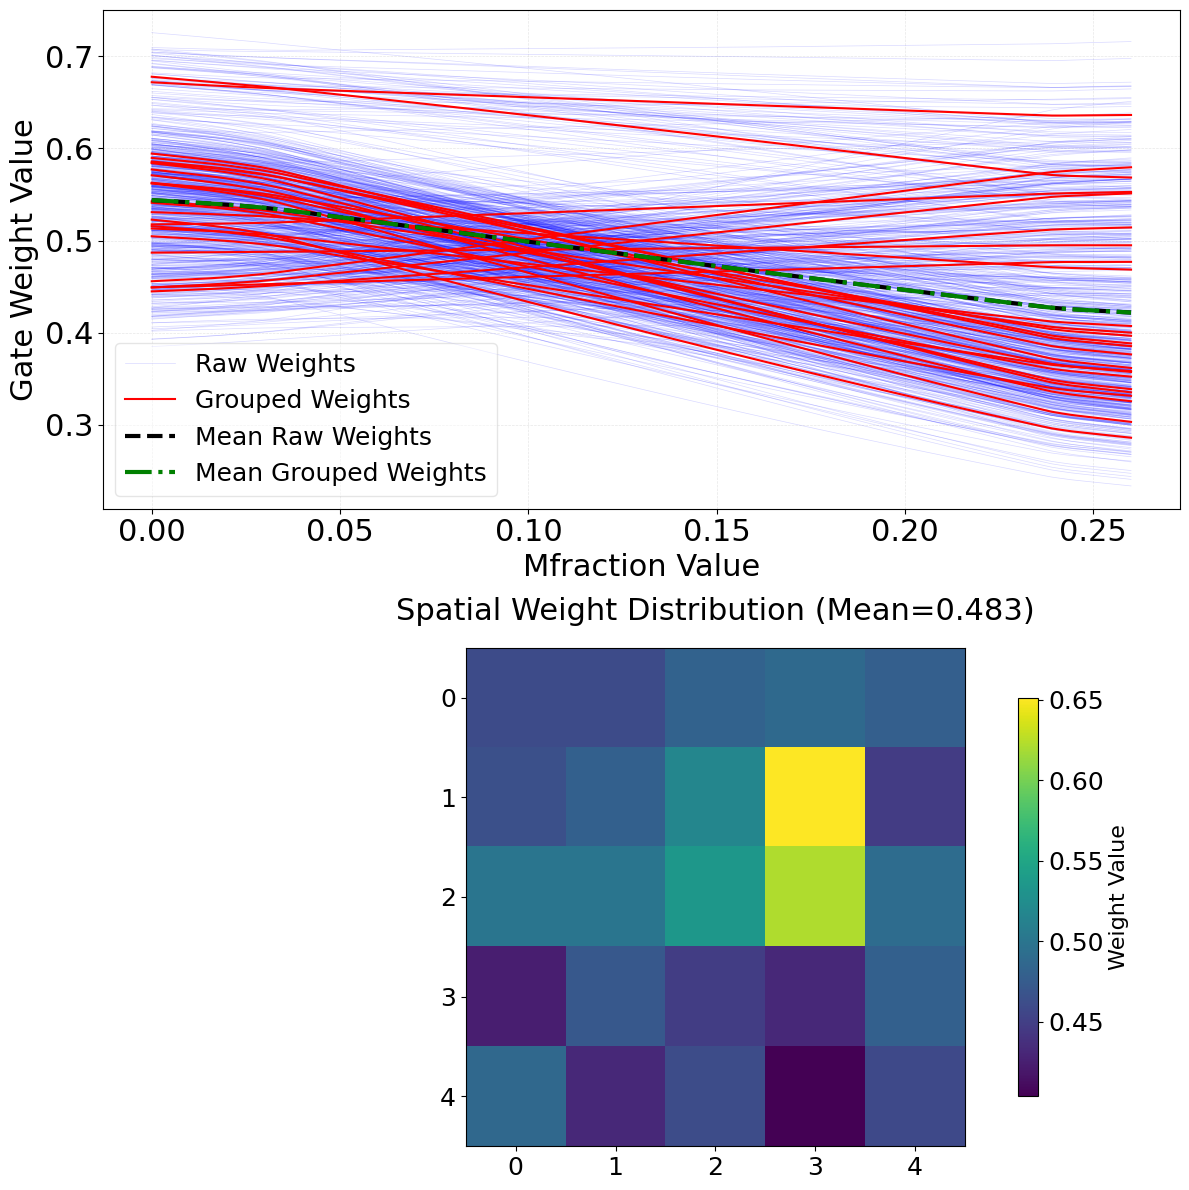

In [5]:
# 4. 可视化结果 - 即时运行
# 训练曲线
# 训练曲线可视化（修改为RMSE）
plt.figure(figsize=(18, 6))
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 22,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 20,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5
})

ax1 = plt.subplot(1, 2, 1)
# 修改处：将MSE转换为RMSE
train_rmse = [np.sqrt(x) for x in train_losses]
val_rmse = [np.sqrt(x) for x in val_losses]
ax1.plot(train_rmse, label='Train RMSE', linewidth=2, color='blue')
ax1.plot(val_rmse, label='Val RMSE', linewidth=2, color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE Loss')  # 修改ylabel
ax1.grid(True)
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(train_r2_scores, label='Train R2', linewidth=2, color='blue')
ax2.plot(val_r2_scores, label='Val R2', linewidth=2, color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R2 Score')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


# 预测结果散点图（保持不变）
plt.figure(figsize=(8, 8))
colors = ['r', 'g', 'b', 'c', 'm']
markers = ['o', 's', 'D', '^', 'v']
labels = [f'{i}' for i in range(5)]
node_metrics = []

for node_id in range(5):
    mask = test_node_ids == node_id
    t = test_targets[mask]
    p = test_preds[mask]

    plt.scatter(t, p, 
               c=colors[node_id], 
               marker=markers[node_id],
               s=90,
               alpha=0.8,
               label=labels[node_id])

    # 修改处：增加RMSE计算
    mse = np.mean((t - p) ** 2)
    rmse = np.sqrt(mse)
    r2 = r2_score(t, p)
    node_metrics.append({
        'node_id': node_id,
        'mse': mse,
        'rmse': rmse,  # 新增RMSE
        'r2': r2,
        'count': len(t)
    })

min_val = 0
max_val = 0.5
plt.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1.5, alpha=0.7)
plt.xlim(-0.02, 0.5)
plt.ylim(-0.02, 0.5)
plt.xticks(np.arange(0, 0.51, 0.1))
plt.yticks(np.arange(0, 0.51, 0.1))
plt.xlabel('True Values', fontsize=20, weight='normal')
plt.ylabel('Predictions', fontsize=20, weight='normal')
plt.grid(True, linestyle='--', alpha=0.3)
legend = plt.legend(title='NodeNum', fontsize=18)
plt.setp(legend.get_title(), fontsize=16)
plt.tight_layout()
plt.show()


# 节点性能评估（增加RMSE输出）
print("\n=== 节点预测性能评估 ===")
print(f"{'节点':<6}{'样本数':<8}{'MSE':<12}{'RMSE':<12}{'R2':<10}")
print("-" * 50)
sorted_by_mse = sorted(node_metrics, key=lambda x: x['mse'])
for metrics in sorted_by_mse:
    print(f"{metrics['node_id']:<6}{metrics['count']:<8}{metrics['mse']:.6f}{metrics['rmse']:.6f}{metrics['r2']:.4f}")

print("\n按R2排序:")
sorted_by_r2 = sorted(node_metrics, key=lambda x: -x['r2'])
for metrics in sorted_by_r2:
    print(f"节点{metrics['node_id']}: R2={metrics['r2']:.4f}, RMSE={metrics['rmse']:.4f}, MSE={metrics['mse']:.6f}")

# 门控响应可视化（保持不变）
model.eval()
test_values = torch.linspace(0, 0.26, 100).unsqueeze(1).to(device)

with torch.no_grad():
    raw_weights = model.fusion.gate(test_values)
    grouped_weights = raw_weights.view(100, 32, 25).mean(dim=1)
    expanded_weights = grouped_weights.unsqueeze(1).repeat(1, 32, 1).view(100, 800)
    mean_raw_weights = raw_weights.mean(dim=1)
    mean_grouped_weights = grouped_weights.mean(dim=1)
    heatmap_data = grouped_weights.mean(dim=0).view(5, 5).cpu()
    mean_spatial_weights = heatmap_data.mean()

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)

for i in range(800):
    plt.plot(test_values.cpu(), raw_weights[:, i].cpu(), 
            color='blue', alpha=0.15, linewidth=0.5, 
            label='Raw Weights' if i == 0 else "")

for i in range(0, 800, 32):
    plt.plot(test_values.cpu(), expanded_weights[:, i].cpu(),
            color='red', linewidth=1.5,
            label='Grouped Weights' if i == 0 else "")

plt.plot(test_values.cpu(), mean_raw_weights.cpu(), 
        color='black', linewidth=3, linestyle='--', 
        label='Mean Raw Weights')
plt.plot(test_values.cpu(), mean_grouped_weights.cpu(),
        color='green', linewidth=3, linestyle='-.', 
        label='Mean Grouped Weights')

plt.xlabel("Mfraction Value", fontsize=22)
plt.ylabel("Gate Weight Value", fontsize=22)
plt.grid(True, alpha=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
          fontsize=18, framealpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=22)

plt.subplot(2, 1, 2)
im = plt.imshow(heatmap_data, cmap='viridis', aspect=1)
plt.title(f"Spatial Weight Distribution (Mean={mean_spatial_weights:.3f})", 
          fontsize=22, pad=20)
cbar = plt.colorbar(im, label='Weight Value', shrink=0.8)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Weight Value', fontsize=16)
plt.xticks(np.arange(5), labels=np.arange(5), fontsize=18)
plt.yticks(np.arange(5), labels=np.arange(5), fontsize=18)

plt.tight_layout()
plt.show()

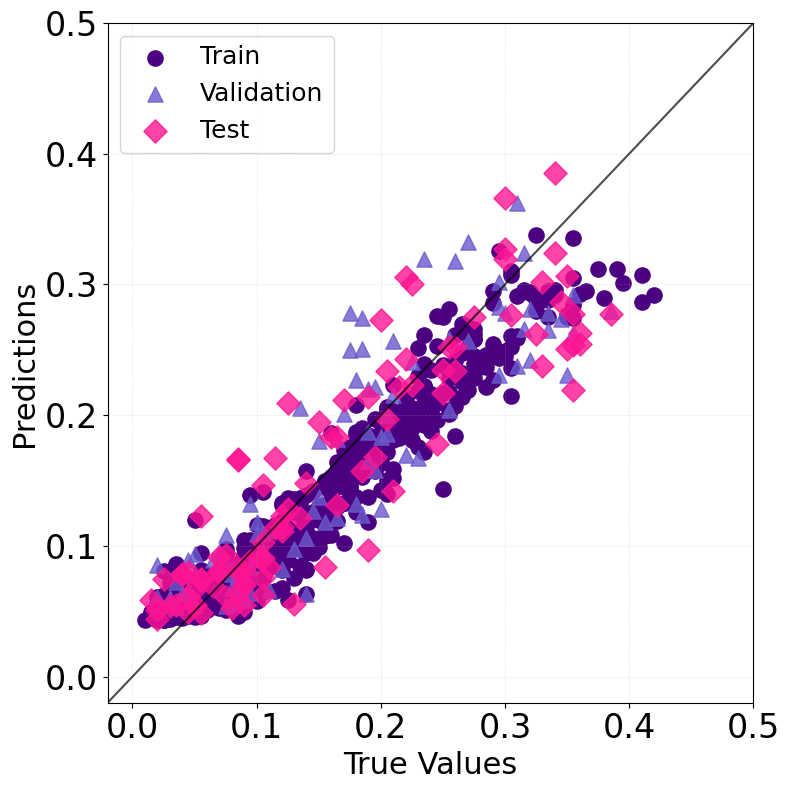

In [12]:
# 预测结果散点图（包含训练/验证/测试集）
plt.figure(figsize=(8, 8))

# 定义数据集样式
dataset_styles = {
    'train': {'color': 'indigo', 'marker': 'o', 'label': 'Train', 'alpha': 1, 's': 120},
    'val': {'color': 'slateblue', 'marker': '^', 'label': 'Validation', 'alpha': 0.8, 's': 120},
    'test': {'color': 'deeppink', 'marker': 'D', 'label': 'Test', 'alpha': 0.8, 's': 140}
}

# 收集所有数据集的预测结果
all_datasets = {
    'train': {'loader': train_loader, 'true': [], 'pred': []},
    'val': {'loader': val_loader, 'true': [], 'pred': []},
    'test': {'loader': test_loader, 'true': [], 'pred': []}
}

# 获取所有预测结果
model.eval()
with torch.no_grad():
    for dataset_name in all_datasets:
        loader = all_datasets[dataset_name]['loader']
        for data in loader:
            data = data.to(device)
            out = model(data)
            all_datasets[dataset_name]['true'].append(data.y.cpu().numpy())
            all_datasets[dataset_name]['pred'].append(out.cpu().numpy())

# 绘制散点图（按数据集区分）
for dataset_name in ['train', 'val', 'test']:
    true_values = np.concatenate(all_datasets[dataset_name]['true'])
    pred_values = np.concatenate(all_datasets[dataset_name]['pred'])
    style = dataset_styles[dataset_name]
    plt.scatter(
        true_values, pred_values,
        c=style['color'],
        marker=style['marker'],
        s=style['s'],
        alpha=style['alpha'],
        label=style['label']
    )

# 绘制理想参考线
min_val = -0.02
max_val = 0.5
plt.plot([min_val, max_val], [min_val, max_val], 'k', linewidth=1.5, alpha=0.7)

# 图表装饰
plt.xlim(-0.02, 0.5)
plt.ylim(-0.02, 0.5)
plt.xlabel('True Values', fontsize=22)
plt.ylabel('Predictions', fontsize=22)
plt.grid(True, linestyle='--', alpha=0.3)

# 设置图例文字大小（关键修改处）
plt.legend(fontsize=18)  # 将fontsize从12改为18

plt.tight_layout()
plt.show()

开始基于边移除的真实GCN边重要性分析

=== GCN Layer 1 分析 ===
正在分析 Layer1 的 4 条边重要性...
已分析 4/4 条边


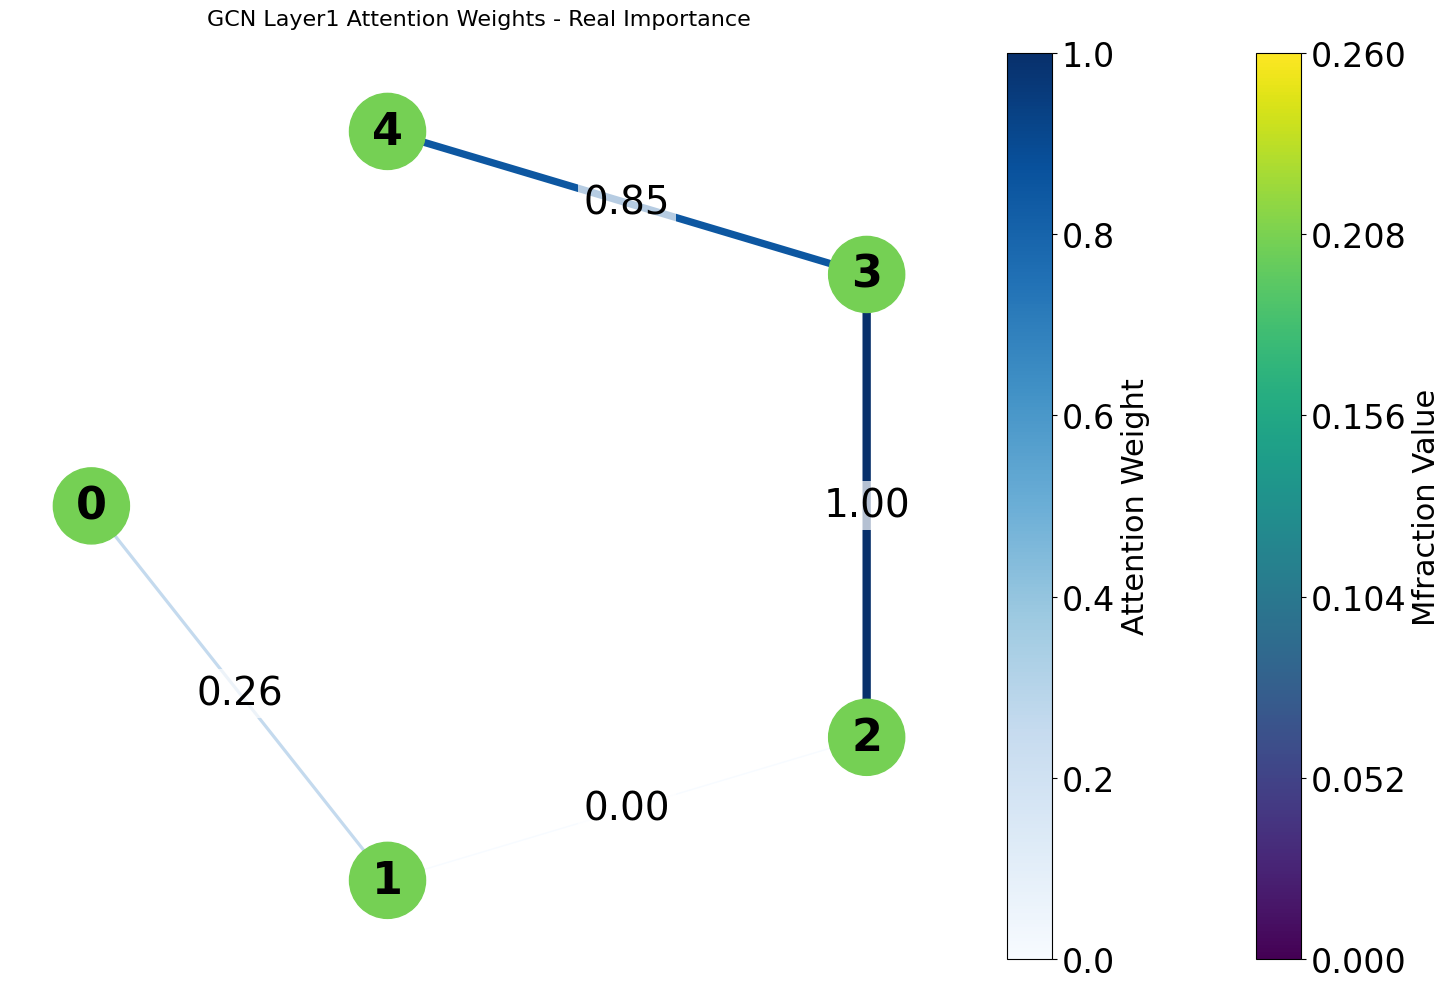


=== GCN Layer 2 分析 ===
正在分析 Layer2 的 4 条边重要性...
已分析 4/4 条边


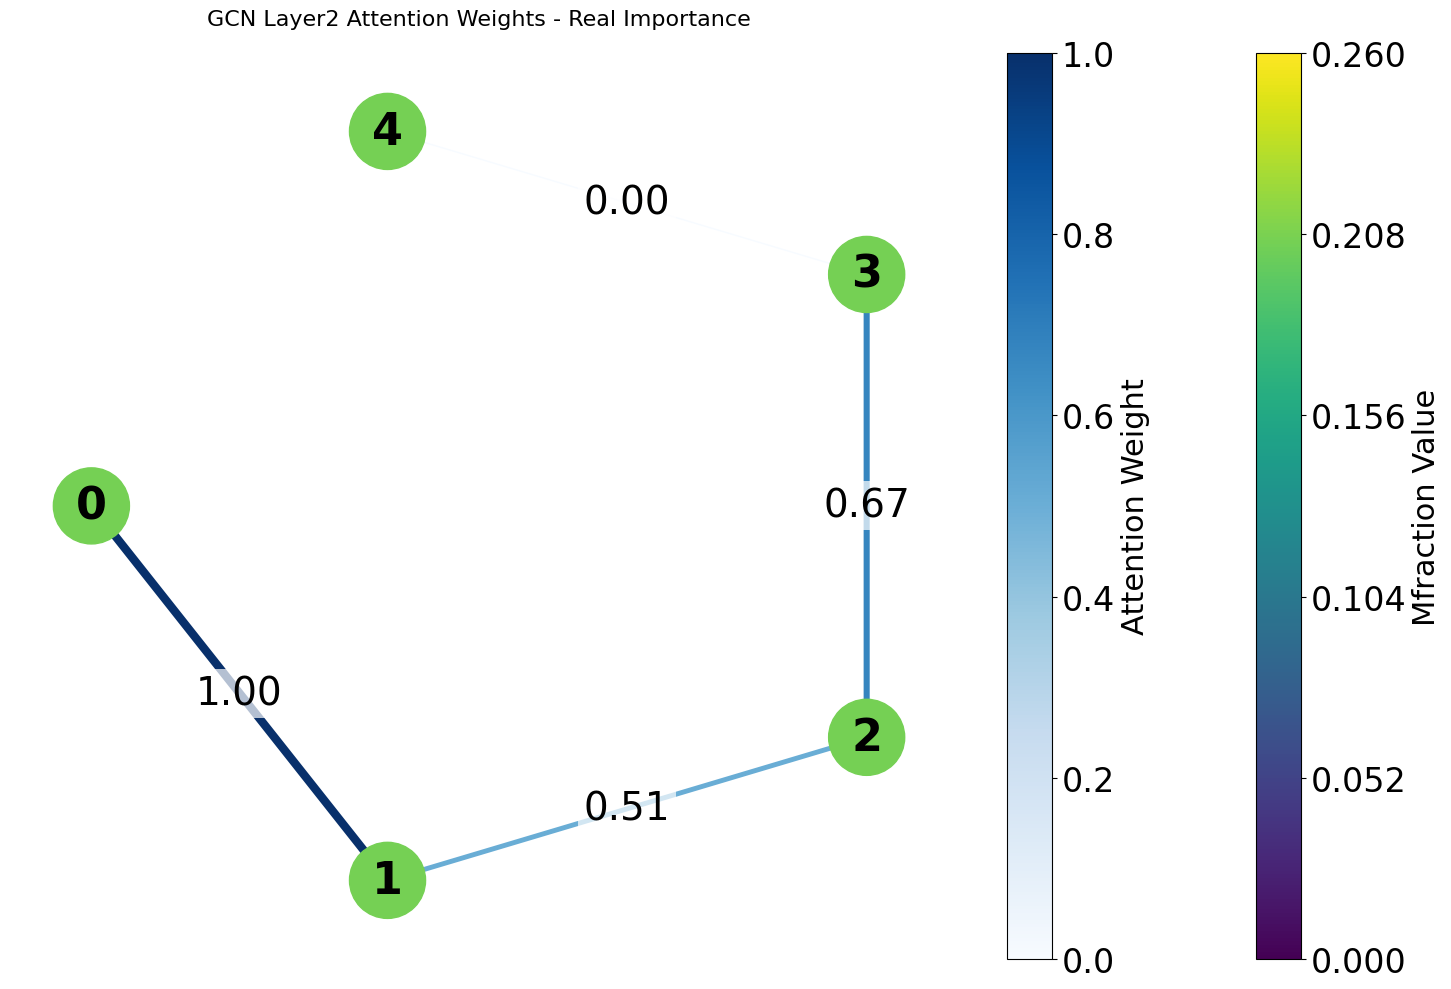


GCN层边重要性对比分析
Layer 1 平均重要性: 0.5267
Layer 2 平均重要性: 0.5454
两层相关性: -0.3640
平均差异: 0.6059
最大差异: 0.8492

=== 详细统计 ===
Layer 1 - 原始损失: 0.001190
Layer 2 - 原始损失: 0.001096

Layer 1 最重要的 3 条边:
  1. 边 2-3: 重要性=1.0000, 影响=-0.000130
  2. 边 3-4: 重要性=0.8492, 影响=-0.000117
  3. 边 0-1: 重要性=0.2575, 影响=-0.000065

Layer 2 最重要的 3 条边:
  1. 边 0-1: 重要性=1.0000, 影响=-0.000143
  2. 边 2-3: 重要性=0.6748, 影响=-0.000115
  3. 边 1-2: 重要性=0.5066, 影响=-0.000101

验证结果: 两层重要性平均差异率 = 0.6059
正常: 两层重要性有明显差异

=== 展示微观结构图像及DamageStrain值 ===

=== 各节点DamageStrain值 ===
Node 0: DamageStrain = 0.01500
Node 1: DamageStrain = 0.07000
Node 2: DamageStrain = 0.07500
Node 3: DamageStrain = 0.08500
Node 4: DamageStrain = 0.10500


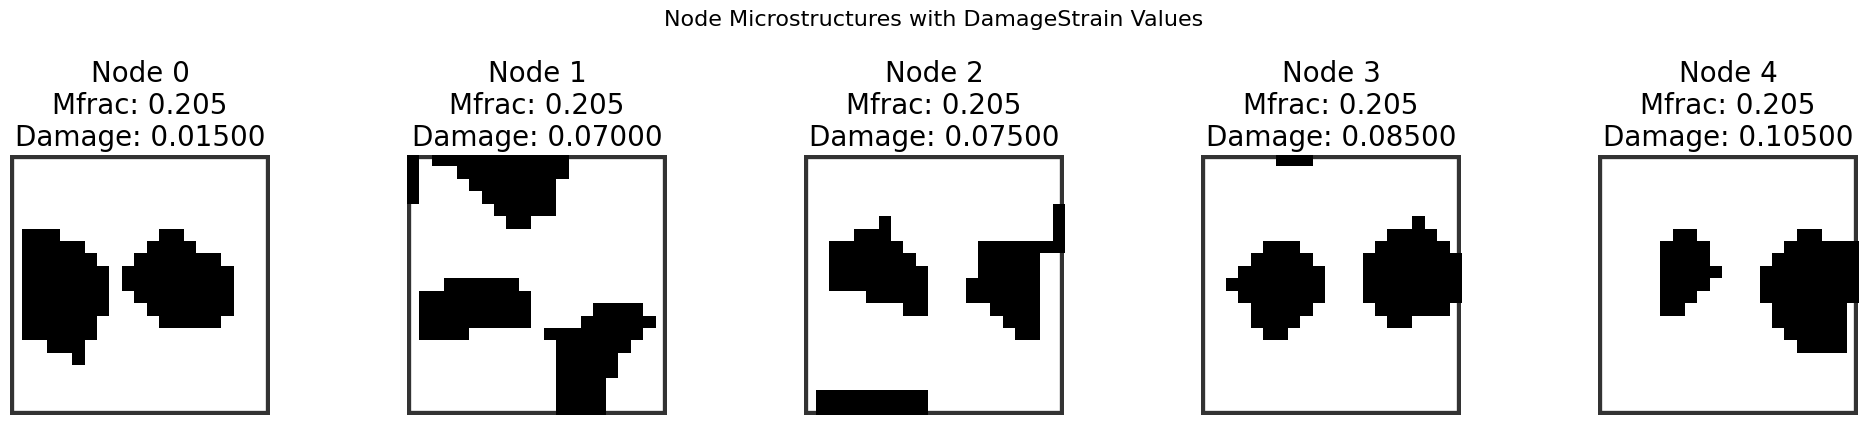

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.metrics import r2_score, mean_squared_error

def calculate_real_edge_importance_by_removal(model, data, layer_name="Layer1", criterion=nn.MSELoss()):

    device = next(model.parameters()).device
    data = data.to(device)
    model.eval()
    
    with torch.no_grad():
        # 获取原始节点特征
        x_all = data.x
        num_nodes = data.num_nodes
        
        # 运行CNN和融合层（固定部分）
        x_cnn = x_all[:, :-1].view(num_nodes, 1, 21, 21)
        x_mfrac = x_all[:, -1].unsqueeze(1)
        
        x_cnn = model.cnn(x_cnn)
        x_cnn = x_cnn.view(num_nodes, -1)
        x, gate_weights = model.fusion(x_cnn, x_mfrac)
        
        edge_index = data.edge_index
        num_edges = edge_index.shape[1]
        
        # 关键修正：分层计算
        if layer_name == "Layer1":
            # Layer 1：使用融合后的特征
            layer_output = F.relu(model.conv1(x, edge_index))
            # 使用节点级预测的损失
            original_loss = criterion(layer_output.mean(dim=1, keepdim=True), data.y).item()
        else:
            # Layer 2：使用Layer 1的输出作为输入
            layer1_output = F.relu(model.conv1(x, edge_index))
            layer_output = F.relu(model.conv2(layer1_output, edge_index))
            original_loss = criterion(layer_output.mean(dim=1, keepdim=True), data.y).item()
        
        edge_importance_scores = []
        edge_removal_effects = []
        
        print(f"正在分析 {layer_name} 的 {num_edges} 条边重要性...")
        
        for edge_idx in range(num_edges):
            # 创建移除单条边的图结构
            mask = torch.ones(num_edges, dtype=torch.bool)
            mask[edge_idx] = False
            
            modified_edge_index = edge_index[:, mask]
            
            if layer_name == "Layer1":
                # Layer 1：使用相同的输入x，但修改边索引
                modified_output = F.relu(model.conv1(x, modified_edge_index))
                modified_loss = criterion(modified_output.mean(dim=1, keepdim=True), data.y).item()
            else:
                # Layer 2：使用Layer 1的输出，但修改边索引
                layer1_output_modified = F.relu(model.conv1(x, modified_edge_index))
                modified_output = F.relu(model.conv2(layer1_output_modified, modified_edge_index))
                modified_loss = criterion(modified_output.mean(dim=1, keepdim=True), data.y).item()
            
            # 计算重要性：损失变化越大，边越重要
            importance = abs(modified_loss - original_loss)
            effect = modified_loss - original_loss
            
            edge_importance_scores.append(importance)
            edge_removal_effects.append(effect)
            
            if (edge_idx + 1) % 10 == 0 or (edge_idx + 1) == num_edges:
                print(f"已分析 {edge_idx + 1}/{num_edges} 条边")
        
        # 归一化重要性分数到[0,1]范围
        importance_scores = np.array(edge_importance_scores)
        if importance_scores.max() > importance_scores.min():
            importance_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min())
        else:
            importance_scores = np.ones_like(importance_scores) * 0.5
        
        return {
            'importance_scores': importance_scores,
            'removal_effects': np.array(edge_removal_effects),
            'original_loss': original_loss,
            'edge_index': edge_index.cpu().numpy(),
            'layer_name': layer_name
        }

def visualize_real_gcn_attention(model, sample_data, importance_results, title_suffix="",
                               node_size=1600, label_font_size=14, edge_width_multiplier=4,
                               edge_label_size=10, show_edge_labels=True, 
                               edge_label_color='darkred', label_pos_offset=0.3):
    """
    可视化真实的GCN边重要性（增强版）
    参数:
        edge_label_color: 边标签字体颜色 (默认'darkred')
        label_pos_offset: 标签位置偏移量 (默认0.3)，用于防止标签遮挡边
    """
    device = next(model.parameters()).device
    sample_data = sample_data.to(device)
    
    importance_scores = importance_results['importance_scores']
    layer_name = importance_results['layer_name']
    
    # 创建网络图
    G = to_networkx(sample_data, to_undirected=True)
    pos = nx.shell_layout(G)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 绘制节点（使用真实的Mfraction值）
    node_features = sample_data.x.detach().cpu().numpy()
    node_colors = node_features[:, -1]  # Mfraction值
    
    # 固定颜色映射范围
    vmin, vmax = 0, 0.26
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                 cmap='viridis', vmin=vmin, vmax=vmax, 
                                 node_size=node_size, ax=ax)
    
    # 添加Mfraction颜色条
    cbar_mfrac = plt.colorbar(nodes, ax=ax, label='Mfraction Value')
    cbar_mfrac.set_ticks([0, 0.052, 0.104, 0.156, 0.208, 0.26])
    
    # 绘制边（使用真实的边重要性）
    edge_widths = importance_scores * edge_width_multiplier + 1
    edge_colors = plt.cm.Blues(importance_scores)
    edges = nx.draw_networkx_edges(G, pos, width=edge_widths,
                                  edge_color=edge_colors, ax=ax)
    
    # 添加边标签（带防遮挡处理）
    if show_edge_labels:
        edge_labels = {}
        label_pos = {}
        
        # 确保边索引与重要性分数对应
        edge_list = list(G.edges())
        for i, (u, v) in enumerate(edge_list):
            if i >= len(importance_scores):
                break  # 防止索引越界
                
            edge_labels[(u, v)] = f"{importance_scores[i]:.2f}"
            
            # 计算标签位置（沿边偏移）
            if u in pos and v in pos:  # 确保节点在位置字典中
                x1, y1 = pos[u]
                x2, y2 = pos[v]
                dx = x2 - x1
                dy = y2 - y1
                length = np.sqrt(dx**2 + dy**2)
                
                if length > 0:
                    dx /= length
                    dy /= length
                    
                # 应用偏移量
                offset_x = label_pos_offset * dy  # 垂直偏移
                offset_y = -label_pos_offset * dx # 垂直偏移
                
                label_pos[(u, v)] = ((x1 + x2)/2 + offset_x, 
                                    (y1 + y2)/2 + offset_y)
        
        # 绘制边标签
        if edge_labels and label_pos:
            nx.draw_networkx_edge_labels(
                G, 
                pos=pos,  # 使用原始布局作为基础
                edge_labels=edge_labels,
                label_pos=0.5,  # 默认中间位置
                font_color=edge_label_color,
                font_size=edge_label_size,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                ax=ax,
                rotate=False  # 不旋转标签
            )
    
    # 添加注意力权重颜色条
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar_attn = plt.colorbar(sm, ax=ax, label='Attention Weight')
    cbar_attn.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # 添加节点标签
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=label_font_size, font_weight='bold')
    
    # 设置标题
    title = f"GCN {layer_name} Attention Weights" + title_suffix
    ax.set_title(title, fontsize=16, pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return importance_scores

def analyze_layer_comparison(layer1_results, layer2_results):
    """
    分析两个GCN层的差异
    """
    layer1_scores = layer1_results['importance_scores']
    layer2_scores = layer2_results['importance_scores']
    
    correlation = np.corrcoef(layer1_scores, layer2_scores)[0,1]
    differences = np.abs(layer1_scores - layer2_scores)
    
    print("\n" + "="*60)
    print("GCN层边重要性对比分析")
    print("="*60)
    
    print(f"Layer 1 平均重要性: {layer1_scores.mean():.4f}")
    print(f"Layer 2 平均重要性: {layer2_scores.mean():.4f}")
    print(f"两层相关性: {correlation:.4f}")
    print(f"平均差异: {differences.mean():.4f}")
    print(f"最大差异: {differences.max():.4f}")
    
    return correlation

def comprehensive_gcn_analysis(model, sample_data, node_size=1600, label_font_size=14, 
                             edge_width_multiplier=4, edge_label_size=10, show_edge_labels=True,
                             edge_label_color='darkred', label_pos_offset=0.3):
    """
    综合GCN边重要性分析
    参数:
        edge_label_color: 边标签字体颜色 (默认'darkred')
        label_pos_offset: 标签位置偏移量 (默认0.3)
    """
    print("="*60)
    print("开始基于边移除的真实GCN边重要性分析")
    print("="*60)
    
    # 分析Layer 1
    print("\n=== GCN Layer 1 分析 ===")
    layer1_results = calculate_real_edge_importance_by_removal(model, sample_data, "Layer1")
    layer1_scores = visualize_real_gcn_attention(
        model, sample_data, layer1_results, 
        " - Real Importance",
        node_size=node_size,
        label_font_size=label_font_size,
        edge_width_multiplier=edge_width_multiplier,
        edge_label_size=edge_label_size,
        show_edge_labels=show_edge_labels,
        edge_label_color=edge_label_color,
        label_pos_offset=label_pos_offset
    )
    
    # 分析Layer 2
    print("\n=== GCN Layer 2 分析 ===")
    layer2_results = calculate_real_edge_importance_by_removal(model, sample_data, "Layer2")
    layer2_scores = visualize_real_gcn_attention(
        model, sample_data, layer2_results, 
        " - Real Importance",
        node_size=node_size,
        label_font_size=label_font_size,
        edge_width_multiplier=edge_width_multiplier,
        edge_label_size=edge_label_size,
        show_edge_labels=show_edge_labels,
        edge_label_color=edge_label_color,
        label_pos_offset=label_pos_offset
    )
    
    # 对比分析
    correlation = analyze_layer_comparison(layer1_results, layer2_results)
    
    # 详细统计
    print("\n=== 详细统计 ===")
    print(f"Layer 1 - 原始损失: {layer1_results['original_loss']:.6f}")
    print(f"Layer 2 - 原始损失: {layer2_results['original_loss']:.6f}")
    
    # 找出最重要的边
    edge_index = layer1_results['edge_index']
    top_k = 3
    
    for layer_name, results in [("Layer 1", layer1_results), ("Layer 2", layer2_results)]:
        scores = results['importance_scores']
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        print(f"\n{layer_name} 最重要的 {top_k} 条边:")
        for i, idx in enumerate(top_indices):
            source, target = edge_index[0, idx], edge_index[1, idx]
            importance = scores[idx]
            effect = results['removal_effects'][idx]
            print(f"  {i+1}. 边 {source}-{target}: 重要性={importance:.4f}, 影响={effect:.6f}")
    
    return layer1_results, layer2_results


def visualize_microstructures_with_damage(sample_data, cmap='gray', figsize=(15, 3), 
                                        border_color='k', border_width=3):
    """
    可视化微观结构并打印DamageStrain值
    """
    import matplotlib.patches as patches
    
    # 获取微观结构数据和DamageStrain值
    micro_features = sample_data.x[:, :-1].view(-1, 21, 21).detach().cpu().numpy()
    mfrac_values = sample_data.x[:, -1].detach().cpu().numpy()
    damage_strains = sample_data.y.detach().cpu().numpy().flatten()
    
    # 打印DamageStrain值
    print("\n=== 各节点DamageStrain值 ===")
    for i, damage in enumerate(damage_strains):
        print(f"Node {i}: DamageStrain = {damage:.5f}")
    
    # 创建图形
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    
    for i, ax in enumerate(axes):
        # 绘制图像
        ax.imshow(micro_features[i], cmap=cmap)
        
        # 创建矩形边框
        rect = patches.Rectangle((-0.5, -0.5), micro_features[i].shape[1], 
                                micro_features[i].shape[0], 
                                linewidth=border_width, edgecolor=border_color, 
                                facecolor='none', alpha=0.8)
        ax.add_patch(rect)
        
        # 在标题中添加DamageStrain信息
        ax.set_title(f'Node {i}\nMfrac: {mfrac_values[i]:.3f}\nDamage: {damage_strains[i]:.5f}', 
                    fontsize=20)
        ax.axis('off')
    
    plt.suptitle("Node Microstructures with DamageStrain Values", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# 修改后的主函数
if __name__ == "__main__":
    sample_data = test_dataset[1]
    
    # 执行综合分析
    layer1_results, layer2_results = comprehensive_gcn_analysis(
        model, sample_data,
        node_size=3000,
        label_font_size=32,
        edge_width_multiplier=5,
        edge_label_size=28,
        show_edge_labels=True,
        edge_label_color='k',
        label_pos_offset=2
    )
    
    # 验证结果差异
    diff_ratio = np.mean(np.abs(layer1_results['importance_scores'] - layer2_results['importance_scores']))
    print(f"\n验证结果: 两层重要性平均差异率 = {diff_ratio:.4f}")
    
    if diff_ratio < 0.1:
        print("警告: 两层重要性差异较小，可能需要检查模型结构")
    else:
        print("正常: 两层重要性有明显差异")
    
    # 在最后展示带DamageStrain值的微观结构图像
    print("\n=== 展示微观结构图像及DamageStrain值 ===")
    visualize_microstructures_with_damage(
        sample_data,
        cmap='gray_r',
        figsize=(20, 4),
        border_color='k',
        border_width=6
    )


正在分析样本 1 (共 87 个样本)
节点数: 5
边数: 4
基于节点移除的真实节点重要性分析（分层）

=== GCN Layer 1 分析 ===
正在分析 Layer1 的 5 个节点重要性...
已分析 5/5 个节点


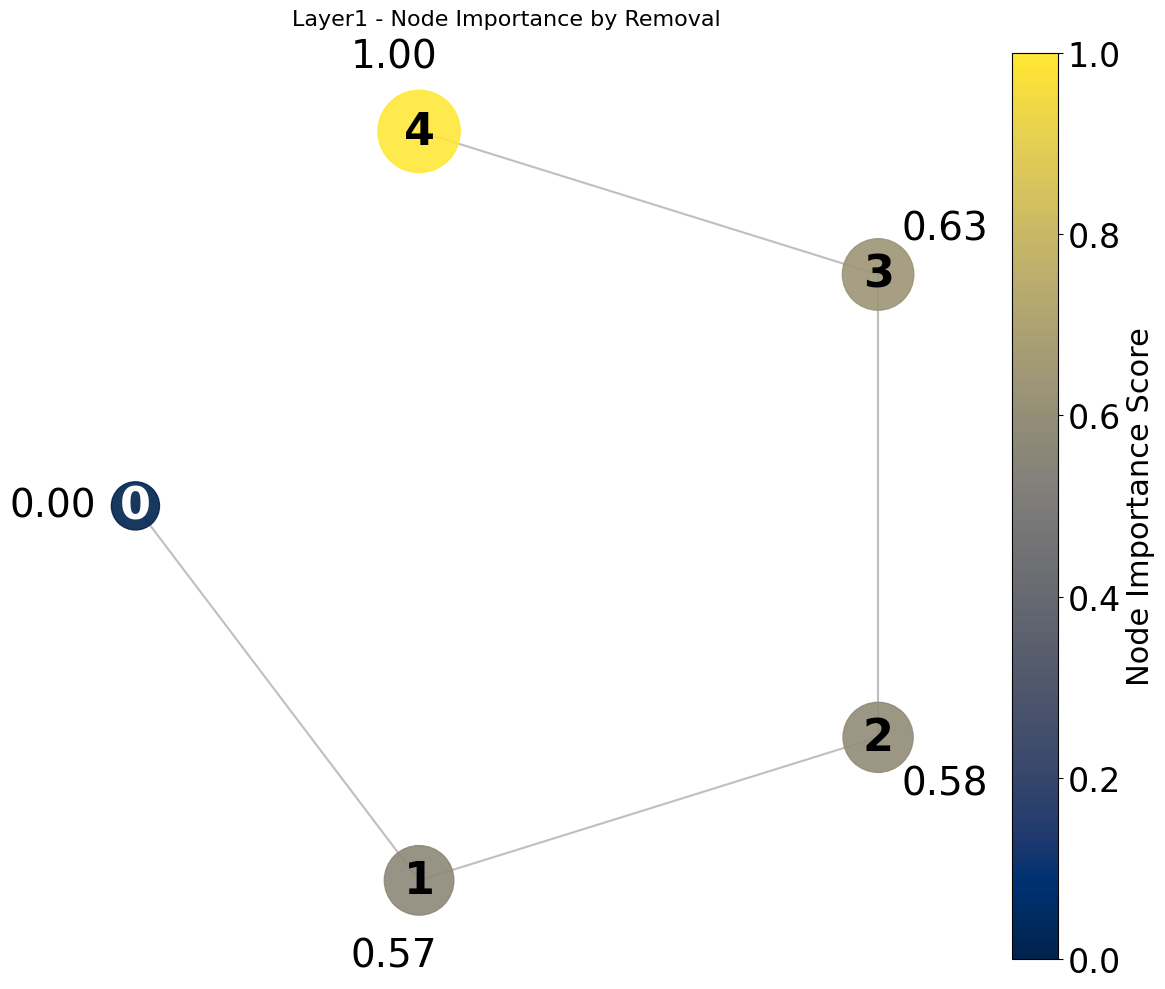


=== GCN Layer 2 分析 ===
正在分析 Layer2 的 5 个节点重要性...
已分析 5/5 个节点


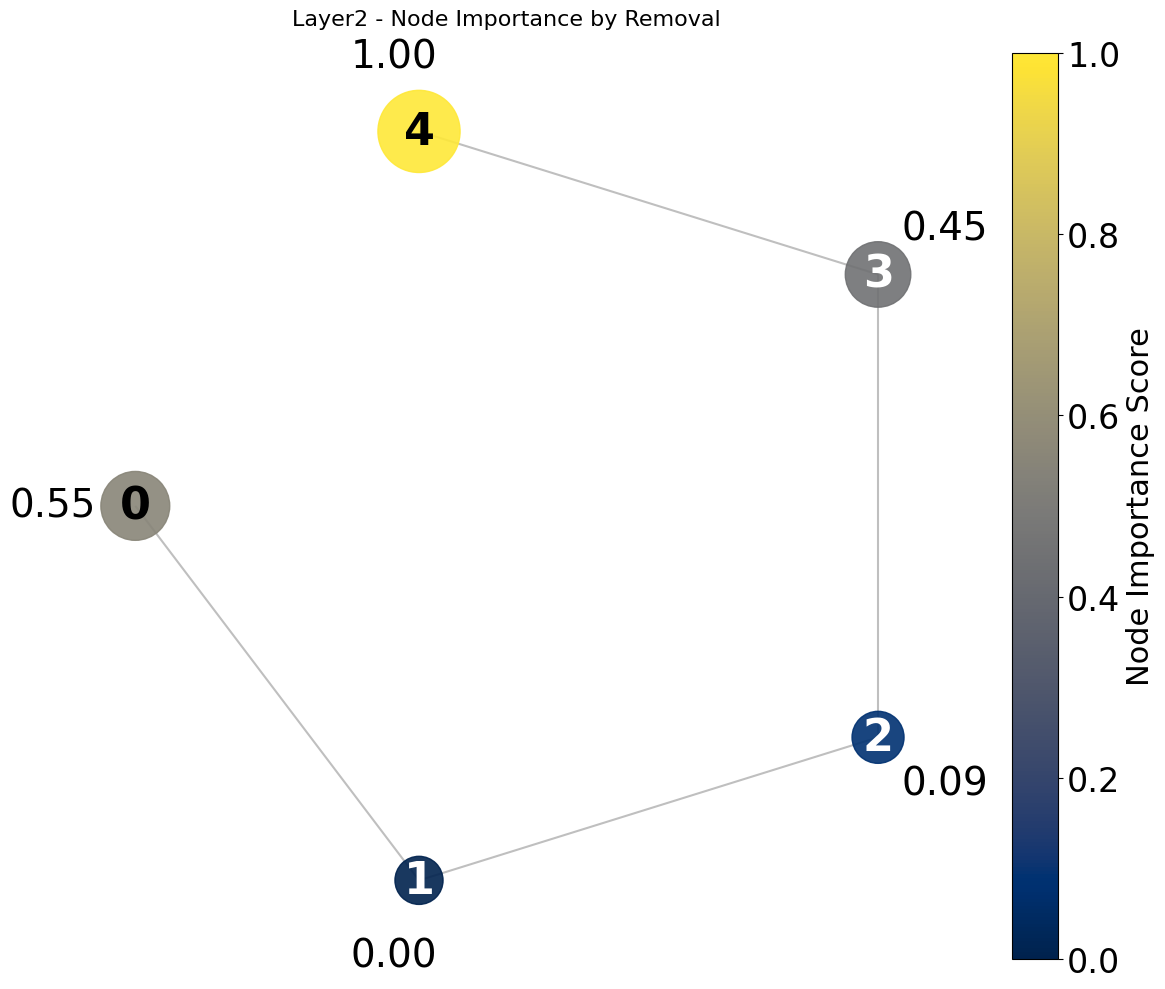


=== 两层节点重要性对比 ===
Layer 1 平均重要性: 0.5562
Layer 2 平均重要性: 0.4162
两层相关性: 0.3041
平均差异: 0.3591
最大差异: 0.5675

Layer 1 最重要的 3 个节点:
  1. 节点 4: 重要性=1.0000, 影响=0.001277
  2. 节点 3: 重要性=0.6292, 影响=0.000854
  3. 节点 2: 重要性=0.5844, 影响=0.000803

Layer 2 最重要的 3 个节点:
  1. 节点 4: 重要性=1.0000, 影响=0.000384
  2. 节点 0: 重要性=0.5477, 影响=-0.000249
  3. 节点 3: 重要性=0.4451, 影响=0.000218

=== 展示微观结构图像及DamageStrain值 ===

=== 各节点DamageStrain值 ===
Node 0: DamageStrain = 0.01500
Node 1: DamageStrain = 0.07000
Node 2: DamageStrain = 0.07500
Node 3: DamageStrain = 0.08500
Node 4: DamageStrain = 0.10500


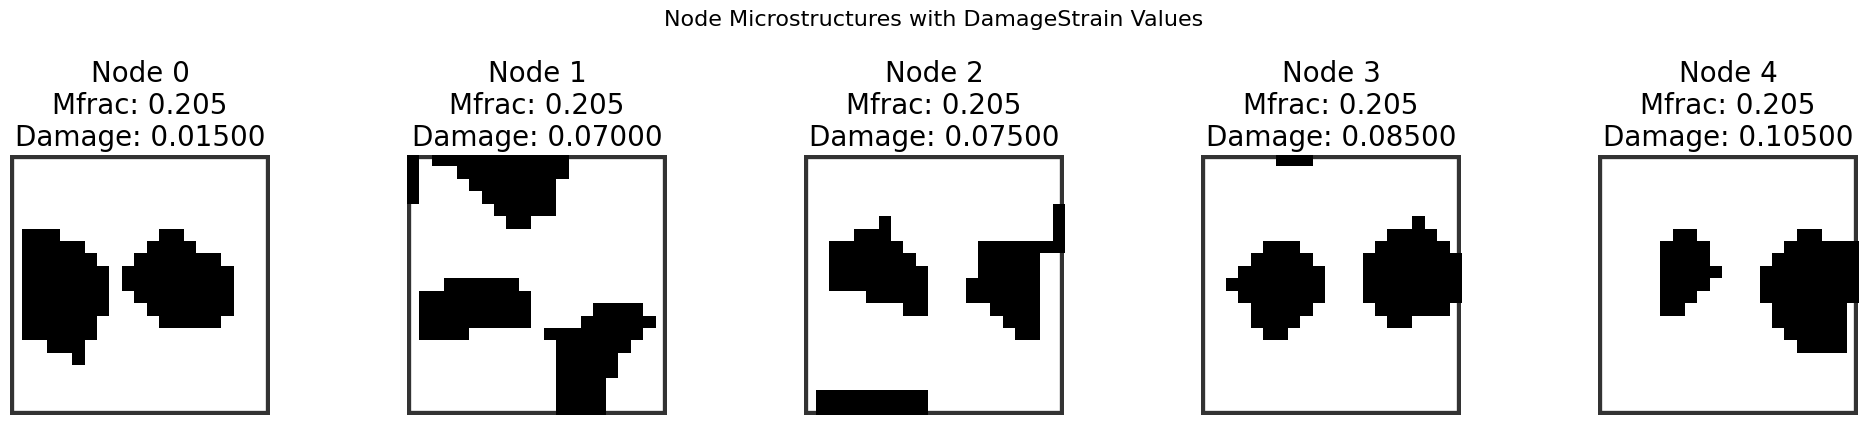


=== 分析完成 ===
样本 1 的节点重要性分析和微观结构可视化已完成


In [8]:
def calculate_node_importance_by_removal(model, data, layer_name="Layer1", criterion=nn.MSELoss()):
    """
    通过节点移除计算真实节点重要性（分层计算）
    """
    device = next(model.parameters()).device
    data = data.to(device)
    model.eval()
    
    with torch.no_grad():
        # 获取原始节点特征
        x_all = data.x
        num_nodes = data.num_nodes
        
        # 运行CNN和融合层（固定部分）
        x_cnn = x_all[:, :-1].view(num_nodes, 1, 21, 21)
        x_mfrac = x_all[:, -1].unsqueeze(1)
        
        x_cnn = model.cnn(x_cnn)
        x_cnn = x_cnn.view(num_nodes, -1)
        x, gate_weights = model.fusion(x_cnn, x_mfrac)
        
        # 关键修正：分层计算
        if layer_name == "Layer1":
            # Layer 1：使用融合后的特征
            layer_output = F.relu(model.conv1(x, data.edge_index))
            original_loss = criterion(layer_output.mean(dim=1, keepdim=True), data.y).item()
        else:
            # Layer 2：使用Layer 1的输出作为输入
            layer1_output = F.relu(model.conv1(x, data.edge_index))
            layer_output = F.relu(model.conv2(layer1_output, data.edge_index))
            original_loss = criterion(layer_output.mean(dim=1, keepdim=True), data.y).item()
        
        node_importance = []
        removal_effects = []
        
        print(f"正在分析 {layer_name} 的 {num_nodes} 个节点重要性...")
        
        for node_idx in range(num_nodes):
            # 创建移除节点的mask（将该节点特征置零）
            modified_x = x.clone()
            modified_x[node_idx] = 0  # 关键操作：移除节点特征
            
            # 同时移除与该节点相连的所有边
            edge_mask = (data.edge_index[0] != node_idx) & (data.edge_index[1] != node_idx)
            modified_edge_index = data.edge_index[:, edge_mask]
            
            if layer_name == "Layer1":
                # Layer 1：使用修改后的特征和边
                modified_output = F.relu(model.conv1(modified_x, modified_edge_index))
                modified_loss = criterion(modified_output.mean(dim=1, keepdim=True), data.y).item()
            else:
                # Layer 2：使用Layer 1的输出
                layer1_output_modified = F.relu(model.conv1(modified_x, modified_edge_index))
                modified_output = F.relu(model.conv2(layer1_output_modified, modified_edge_index))
                modified_loss = criterion(modified_output.mean(dim=1, keepdim=True), data.y).item()
            
            # 计算重要性指标
            importance = abs(modified_loss - original_loss)
            effect = modified_loss - original_loss  # 正影响表示重要节点
            
            node_importance.append(importance)
            removal_effects.append(effect)
            
            if (node_idx + 1) % 5 == 0 or (node_idx + 1) == num_nodes:
                print(f"已分析 {node_idx + 1}/{num_nodes} 个节点")
        
        # 归一化重要性分数到[0,1]范围
        importance_scores = np.array(node_importance)
        if importance_scores.max() > importance_scores.min():
            importance_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min())
        else:
            importance_scores = np.ones_like(importance_scores) * 0.5
        
        return {
            'importance_scores': importance_scores,
            'removal_effects': np.array(removal_effects),
            'original_loss': original_loss,
            'node_features': data.x.cpu().numpy(),
            'edge_index': data.edge_index.cpu().numpy(),
            'layer_name': layer_name
        }

def visualize_node_importance(model, data, importance_results, title="Node Importance by Removal",
                            inner_label_size=10, outer_label_size=8, label_offset=0.15,
                            min_node_size=800, max_node_size=2800):
    """
    可视化节点重要性（增强版）
    参数:
        inner_label_size: 圆圈内部序号标签大小
        outer_label_size: 圆圈外部重要性标签大小
        label_offset: 外部标签偏移量
        min_node_size: 最小节点大小（默认800）
        max_node_size: 最大节点大小（默认2800）
    """
    device = next(model.parameters()).device
    data = data.to(device)
    
    importance_scores = importance_results['importance_scores']
    layer_name = importance_results['layer_name']
    
    # 创建网络图
    G = to_networkx(data, to_undirected=True)
    pos = nx.shell_layout(G)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 计算节点大小（基于重要性分数线性插值）
    node_sizes = min_node_size + (max_node_size - min_node_size) * importance_scores
    
    # 绘制节点（颜色表示重要性）
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=importance_scores,
        cmap='cividis',
        vmin=0, vmax=1,
        alpha=0.9,
        ax=ax
    )
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Node Importance Score')
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # 绘制边（灰色半透明）
    nx.draw_networkx_edges(
        G, pos,
        width=1.5,
        edge_color='gray',
        alpha=0.5,
        ax=ax
    )
    
    # 添加节点标签（分内外两层）
    for node_idx, (x, y) in pos.items():
        # 内部标签（节点序号）
        ax.text(x, y, str(node_idx), 
               fontsize=inner_label_size, 
               fontweight='bold',
               ha='center', va='center',
               color='black' if importance_scores[node_idx] > 0.5 else 'white')
        
        # 外部标签（重要性分数）
        if importance_scores[node_idx] >= 0:
            # 计算标签位置（沿半径向外偏移）
            radius = np.sqrt(node_sizes[node_idx]) / 100
            angle = np.arctan2(y, x) if x != 0 else np.pi/2
            offset_x = label_offset * np.cos(angle)
            offset_y = label_offset * np.sin(angle)
            
            ax.text(x + offset_x, y + offset_y, 
                   f"{importance_scores[node_idx]:.2f}",
                   fontsize=outer_label_size,
                   fontweight='normal',
                   ha='center', va='center',
                   )#bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    
    ax.set_title(f"{layer_name} - {title}", fontsize=16, pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def comprehensive_node_importance_analysis(model, sample_data,
                                         inner_label_size=32,
                                         outer_label_size=28,
                                         label_offset=0.225,
                                         min_node_size=2000,
                                         max_node_size=5000):
    """
    综合节点重要性分析（完整版）
    """
    print("="*60)
    print("基于节点移除的真实节点重要性分析（分层）")
    print("="*60)
    
    # 分析Layer 1
    print("\n=== GCN Layer 1 分析 ===")
    layer1_results = calculate_node_importance_by_removal(model, sample_data, "Layer1")
    visualize_node_importance(
        model, sample_data, layer1_results,
        inner_label_size=inner_label_size,
        outer_label_size=outer_label_size,
        label_offset=label_offset,
        min_node_size=min_node_size,
        max_node_size=max_node_size
    )
    
    # 分析Layer 2
    print("\n=== GCN Layer 2 分析 ===")
    layer2_results = calculate_node_importance_by_removal(model, sample_data, "Layer2")
    visualize_node_importance(
        model, sample_data, layer2_results,
        inner_label_size=inner_label_size,
        outer_label_size=outer_label_size,
        label_offset=label_offset,
        min_node_size=min_node_size,
        max_node_size=max_node_size
    )
    
    # 对比分析两层结果
    print("\n=== 两层节点重要性对比 ===")
    correlation = np.corrcoef(layer1_results['importance_scores'], 
                             layer2_results['importance_scores'])[0,1]
    differences = np.abs(layer1_results['importance_scores'] - layer2_results['importance_scores'])
    
    print(f"Layer 1 平均重要性: {layer1_results['importance_scores'].mean():.4f}")
    print(f"Layer 2 平均重要性: {layer2_results['importance_scores'].mean():.4f}")
    print(f"两层相关性: {correlation:.4f}")
    print(f"平均差异: {differences.mean():.4f}")
    print(f"最大差异: {differences.max():.4f}")
    
    # 找出最重要的节点
    top_k = 3
    for layer_name, results in [("Layer 1", layer1_results), ("Layer 2", layer2_results)]:
        scores = results['importance_scores']
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        print(f"\n{layer_name} 最重要的 {top_k} 个节点:")
        for i, idx in enumerate(top_indices):
            importance = scores[idx]
            effect = results['removal_effects'][idx]
            print(f"  {i+1}. 节点 {idx}: 重要性={importance:.4f}, 影响={effect:.6f}")
    
    return layer1_results, layer2_results

if __name__ == "__main__":
    # 设置随机种子确保可重复性
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 选择样本进行分析
    sample_idx = 1  # 可以修改为任意样本索引
    sample_data = test_dataset[sample_idx]
    
    # 打印样本基本信息
    print(f"\n正在分析样本 {sample_idx} (共 {len(train_dataset)} 个样本)")
    print(f"节点数: {sample_data.num_nodes}")
    print(f"边数: {sample_data.edge_index.shape[1]}")
    
    # 执行节点重要性分析
    layer1_results, layer2_results = comprehensive_node_importance_analysis(
        model, sample_data,
        inner_label_size=32,
        outer_label_size=28,
        label_offset=0.2,
        min_node_size=1200,
        max_node_size=3500
    )
    
    # 在最后展示微观结构图像和DamageStrain值
    print("\n=== 展示微观结构图像及DamageStrain值 ===")
    visualize_microstructures_with_damage(
        sample_data,
        cmap='gray_r',
        figsize=(20, 4),
        border_color='k',
        border_width=6
    )
    
    # 打印分析完成信息
    print("\n=== 分析完成 ===")
    print(f"样本 {sample_idx} 的节点重要性分析和微观结构可视化已完成")

In [9]:
# 在可视化部分开始前添加
print("\n=== 可视化数据检查 ===")
for dataset_name in ['train', 'test']:
    true_values = np.concatenate(all_datasets[dataset_name]['true'])
    pred_values = np.concatenate(all_datasets[dataset_name]['pred'])
    
    print(f"{dataset_name}集 - 真实值范围: [{np.min(true_values):.4f}, {np.max(true_values):.4f}]")
    print(f"{dataset_name}集 - 预测值范围: [{np.min(pred_values):.4f}, {np.max(pred_values):.4f}]")
    print(f"{dataset_name}集 - 负值预测数量: {np.sum(pred_values < 0)}")
    print(f"{dataset_name}集 - 负值比例: {np.mean(pred_values < 0):.2%}")
    print("-" * 50)


=== 可视化数据检查 ===
train集 - 真实值范围: [0.0100, 0.4200]
train集 - 预测值范围: [0.0430, 0.3380]
train集 - 负值预测数量: 0
train集 - 负值比例: 0.00%
--------------------------------------------------
test集 - 真实值范围: [0.0150, 0.3850]
test集 - 预测值范围: [0.0443, 0.3856]
test集 - 负值预测数量: 0
test集 - 负值比例: 0.00%
--------------------------------------------------


MicroInfo 文件: ['Case553_Int3_Local_MicroInfo_Size21_1.txt', 'Case553_Int3_Local_MicroInfo_Size21_2.txt', 'Case553_Int3_Local_MicroInfo_Size21_3.txt', 'Case553_Int3_Local_MicroInfo_Size21_4.txt', 'Case553_Int3_Local_MicroInfo_Size21_5.txt']
已加载训练好的最佳模型

=== 可视化函数内部数据检查 ===
当前样本真实值范围: [0.0250, 0.1700]
当前样本预测值范围: [0.0504, 0.1735]
当前样本负值预测数量: 0


C:\Users\86157\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


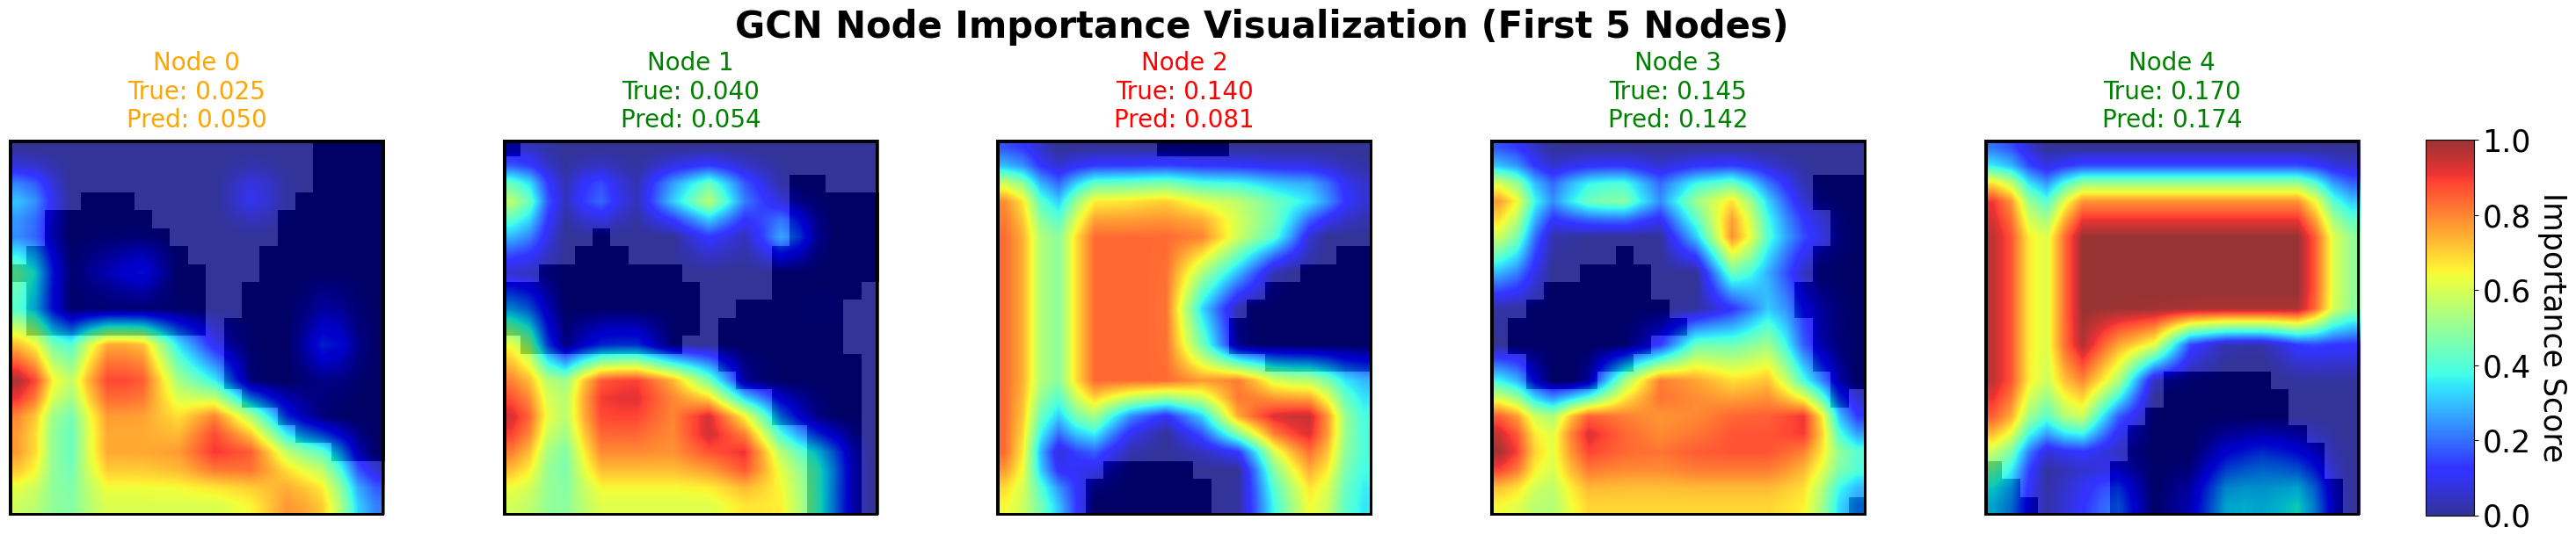

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F
import cv2  # 添加OpenCV导入
import os

def set_deterministic():
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def plot_gcn_importance(model, sample_data, n=5, cols=5, 
                       cbar_label_size=25, cbar_tick_size=25, title_fontsize=30):
    """
    可视化GCN节点重要性
    参数:
        model: 训练好的模型
        sample_data: 单个图数据样本
        n: 要可视化的节点数量
        cols: 每行显示的节点数量
        cbar_label_size: 颜色条标签字体大小
        cbar_tick_size: 颜色条刻度字体大小
        title_fontsize: 标题字体大小
    """
    
    # === 添加调试检查 ===
    print("\n=== 可视化函数内部数据检查 ===")
    device = next(model.parameters()).device
    sample_data = sample_data.to(device)
    
    # 检查输入数据的真实值
    y_true_check = sample_data.y.cpu().numpy().flatten()
    print(f"当前样本真实值范围: [{np.min(y_true_check):.4f}, {np.max(y_true_check):.4f}]")
    
    # 检查模型预测值
    with torch.no_grad():
        y_pred_check = model(sample_data).cpu().numpy().flatten()
    print(f"当前样本预测值范围: [{np.min(y_pred_check):.4f}, {np.max(y_pred_check):.4f}]")
    print(f"当前样本负值预测数量: {np.sum(y_pred_check < 0)}")
    print("=" * 60)
    
    
    # 数据准备
    device = next(model.parameters()).device
    sample_data = sample_data.to(device)
    
    # 前向传播获取预测值
    with torch.no_grad():
        y_pred = model(sample_data).cpu().numpy().flatten()
    y_true = sample_data.y.cpu().numpy().flatten()
    abs_errors = np.abs(y_true - y_pred)
    
    # 计算误差分位数
    p50, p75 = np.percentile(abs_errors, [50, 75])
    
    # 获取微观结构数据
    micro_features = sample_data.x[:, :-1].view(-1, 21, 21).cpu().numpy()
    
    # 创建可视化
    rows = int(np.ceil(n / cols))
    fig = plt.figure(figsize=(cols*6, rows*6), dpi=100)  # 调整整体尺寸
    
    # 使用GridSpec创建更灵活的布局
    gs = GridSpec(rows, cols + 1, figure=fig, width_ratios=[1]*cols + [0.1])
    
    # 存储热图对象用于颜色条
    heatmap_im = None
    
    for i in range(min(n, len(micro_features))):  # 确保不超过实际节点数
        row = i // cols
        col = i % cols
        ax = fig.add_subplot(gs[row, col])
        
        # --- 1. 绘制带边框的原始图像 ---
        bordered_img = np.ones((23, 23))  # 添加1像素边框
        bordered_img[1:-1, 1:-1] = micro_features[i]
        ax.imshow(bordered_img, cmap='binary')
        
        # --- 2. 绘制黑色边框 ---
        border = patches.Rectangle((0.5, 0.5), 21, 21,
                                 linewidth=5.0,
                                 edgecolor='black',
                                 facecolor='none',
                                 zorder=10)
        ax.add_patch(border)
        
        # --- 3. 计算Respond-CAM热图 ---
        heatmap = compute_respond_cam(model, micro_features[i])
        if heatmap.max() > 1e-5:
        # --- 4. 热力图叠加 ---
            im = ax.imshow(heatmap,
                         extent=[0.5, 21.5, 21.5, 0.5],
                         cmap='jet',
                         alpha=0.8,
                         vmin=0,
                         vmax=1,
                         interpolation='bilinear',
                         zorder=5)
            heatmap_im = im  # 保存最后一个热图对象用于颜色条
        
        # --- 5. 标题设置 ---
        error = abs_errors[i]
        title_color = 'red' if error > p75 else 'orange' if error > p50 else 'green'
        ax.set_title(f"Node {i}\nTrue: {y_true[i]:.3f}\nPred: {y_pred[i]:.3f}", 
                    fontsize=20, color=title_color, pad=10)
        ax.axis('off')
    
    # --- 6. 颜色条设置（与图像等高）---
    if n > 0 and heatmap_im is not None:
        # 创建与图像等高的颜色条区域
        cax = fig.add_subplot(gs[:, -1])  # 占用所有行的最后一列
        
        # 创建颜色条
        cbar = fig.colorbar(heatmap_im, cax=cax, orientation='vertical')
        
        # 设置颜色条标签和刻度字体大小
        cbar.set_label('Importance Score', 
                      fontsize=cbar_label_size, 
                      rotation=270,
                      labelpad=30)  # 调整标签位置
        
        # 设置刻度字体大小
        cbar.ax.tick_params(labelsize=cbar_tick_size)
        
        # 设置刻度值（可选）
        cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    plt.suptitle(f"GCN Node Importance Visualization (First {n} Nodes)", 
                y=1.02, fontsize=title_fontsize, weight='bold')
    plt.tight_layout()
    plt.show()

class RespondCAM:
    def __init__(self, model):
        self.model = model
        self.features = None
        self.gradients = None
        self.model.eval()
        self.register_hooks()
    
    def register_hooks(self):
        def forward_hook(module, input, output):
            self.features = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        # 在CNN的最后一个卷积层注册钩子
        if hasattr(self.model, 'cnn'):
            for layer in reversed(list(self.model.cnn.children())):
                if isinstance(layer, torch.nn.Conv2d):
                    layer.register_forward_hook(forward_hook)
                    layer.register_backward_hook(backward_hook)
                    break

def compute_respond_cam(model, micro_structure):
    """计算微观结构的Respond-CAM热图"""
    respond_cam = RespondCAM(model)
    input_tensor = torch.tensor(micro_structure, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    input_tensor.requires_grad = True
    
    # 前向传播
    output = model.cnn(input_tensor)
    target = output.mean()
    
    # 反向传播
    model.zero_grad()
    target.backward()
    
    # 计算热图
    if respond_cam.features is not None and respond_cam.gradients is not None:
        weights = torch.mean(respond_cam.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * respond_cam.features, dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max() if cam.max() > 0 else cam
        
        # 上采样到原始尺寸
        cam = cam.squeeze().detach().numpy()
        cam = cv2.resize(cam, (21, 21), interpolation=cv2.INTER_LINEAR)
        return cam
    return np.zeros((21, 21))

# 使用示例
if __name__ == "__main__":
    set_deterministic() 
    
    # 检查数据长度是否匹配
    total_samples = len(train_dataset) + len(val_dataset) + len(test_dataset)
    assert len(file_info) == total_samples, "file_info长度与数据集不匹配"
    
    # 选择测试集的第2个样本（索引1）
    sample_idx = 1
    sample_data = train_dataset[sample_idx]
    
    # 计算在file_info中的对应位置
    file_info_idx = len(train_dataset) + len(val_dataset) + sample_idx
    micro_files = file_info[file_info_idx]['micro']
    micro_filenames = [os.path.basename(f) for f in micro_files]
    print(f"MicroInfo 文件: {micro_filenames}")
    
    # === 关键修改：确保模型架构与权重匹配 ===
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Optimized_CNN_GCN(
        filters=32,  # 必须与权重文件一致
        kernel_size=5,
        dense_units=128,
        dropout_rate=0.2,
        gcn_hidden_dim=32,
        learning_rate=0.0015
    ).to(device)

    # 加载权重
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    print("已加载训练好的最佳模型")
    
    # 可视化
    plot_gcn_importance(
        model, 
        sample_data, 
        n=5, 
        cols=5,
        cbar_label_size=25,    
        cbar_tick_size=25,   
        title_fontsize=30
    )